In [1]:
import sys
sys.path.extend(["../", "../src"])

In [2]:
from tqdm import tqdm
from memory_profiler import memory_usage
import numpy as np
from scipy.stats import poisson

import matplotlib
import matplotlib.pyplot as plt
import torch as th
from torch.utils.data import TensorDataset


from src.loss import phase_insensitive_loss_cvx
from src.gd_opt import learn_phase_insensitive_povm
from src.quantum import pnr_povm
from src.utils import find_lambda_max
from src.custom_types import Hyperparameters

matplotlib.rcParams.update({"font.size": 16})
plt.rcParams["figure.dpi"] = 125 #200  # set fig resolution
plt.rcParams.update({"text.usetex": True, "font.family": "Helvetica"})

seed = 42  # for reproducibility
th.manual_seed(seed);

### Memory complexity

In [3]:
Ms = range(100, 200, 25)
device = 'cpu'
N = 25
D = 2000
eta = 0.85
lam_smoothing = 1e-5
mem_gd = []
mem_mosek = []
avg_fids_mosek = []
hyperparams = Hyperparameters(lr=0.01, lr_decay=0.999, beta1=0.9, beta2=0.9, num_epochs=100, batch_size=25)

In [ ]:
for M in tqdm(Ms, desc="Performing memory experiments"):
    # PNR detector POVM
    true_povm = pnr_povm(hilbert_dim=M, N=N, eta=eta)
    true_povm = th.vstack( [th.diagonal(E) for E in true_povm] ).T

    max_avg = find_lambda_max(M, eps=1e-5)  # get max avg photon number for probes
    n_bars = np.linspace(0, max_avg, D)
    probes = th.tensor(np.array([ poisson.pmf(k=list(range(M)), mu=n_bar) for n_bar in n_bars ]), dtype=th.float32) 

    targets = probes @ true_povm  

    M, N, = probes.shape[1], targets.shape[1]
    logits = th.rand((M, N)) - 1
    logits = logits.to(device)
    logits.requires_grad = True

    probes = probes.to(device, dtype=th.float32)
    targets = targets.to(device)
    dataset = TensorDataset(probes, targets)

    # compute mems
    base_line = memory_usage(timeout=1)[0]
    mem = memory_usage( (learn_phase_insensitive_povm, (logits, hyperparams, dataset, lam_smoothing, False)), interval=0.5, max_usage=True, include_children=True) - base_line 
    mem_gd.append(mem / 1000)  # mem is in Mb divide by 1k to get in Gb

    targets, probes = targets.cpu().numpy(), probes.cpu().numpy()
    base_line = memory_usage(timeout=1)[0]
    mem = memory_usage( (phase_insensitive_loss_cvx, (targets, probes, lam_smoothing, "MOSEK")), interval=0.5, max_usage=True, include_children=True) - base_line  
    mem_mosek.append(mem / 1000)

Performing memory experiments: 100%|██████████| 4/4 [01:42<00:00, 25.55s/it]


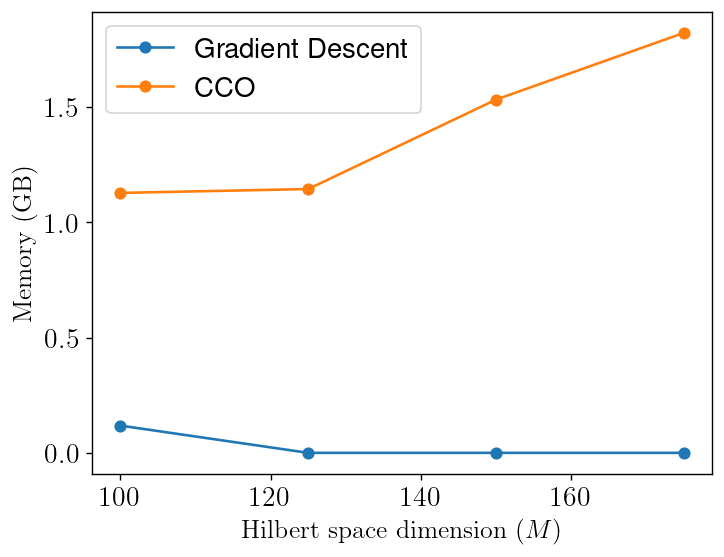

In [5]:
plt.plot(Ms, mem_gd, label="Gradient Descent", marker="o")
plt.plot(Ms, mem_mosek, label="CCO", marker="o")
plt.xlabel(r"\textrm{Hilbert space dimension} $(M)$", fontsize=15)
plt.ylabel(r"\textrm{Memory (GB)}", fontsize=15)
# plt.yscale("log")
plt.legend();

if eta < 1.0:
    plt.savefig("figs/lossy_memory.png", dpi=300)
else:
    plt.savefig("figs/ideal_memory.png", dpi=300)